In [1]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [2]:
# setup
# experiments with MNIST dataset
x_dim = 784
k = 20
epoch_to_load = 20 # Load the model 
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
trials = 20
opt = Flux.Optimise.ADAM(.1);

encoder_μ, encoder_logvar, decoder_inco, W3_inco = load_model_identity("trained_GNN/MNIST_identity", epoch_to_load)
W1_inco = Flux.params(decoder_inco)[1]
W2_inco = Flux.params(decoder_inco)[2]
encoder_μ, encoder_logvar, decoder_co = load_model("trained_GNN/MNIST", epoch_to_load)
W3_co = Flux.params(decoder_co)[3]
W1_co = Flux.params(decoder_co)[1]
W2_co = Flux.params(decoder_co)[2]

z = randn(k) # ground code vector
F = dct(diagm(ones(x_dim)),2);

# β_list, α_list = get_β_α(F, W3_co, W3_inco, 21);
# m_list = 20:20:440


Loading model...

Done


Loading model...Done

784×784 Matrix{Float64}:
 0.0357143   0.0505075  0.0505072   0.0505067  …   0.00020239    0.000101195
 0.0357143   0.0505067  0.050504    0.0504994     -0.000607158  -0.000303584
 0.0357143   0.0505051  0.0504975   0.0504848      0.00101189    0.000505969
 0.0357143   0.0505027  0.0504878   0.0504629     -0.00141655   -0.000708345
 0.0357143   0.0504994  0.0504748   0.0504337      0.00182112    0.000910709
 0.0357143   0.0504954  0.0504586   0.0503973  …  -0.00222558   -0.00111306
 0.0357143   0.0504905  0.0504391   0.0503535      0.00262989    0.00131539
 0.0357143   0.0504848  0.0504164   0.0503025     -0.00303403   -0.0015177
 0.0357143   0.0504783  0.0503905   0.0502442      0.00343798    0.00171999
 0.0357143   0.050471   0.0503613   0.0501786     -0.00384171   -0.00192225
 ⋮                                             ⋱                
 0.0357143  -0.0504783  0.0503905  -0.0502442  …   0.00343798   -0.00171999
 0.0357143  -0.0504848  0.0504164  -0.0503025     -0.00303403    0.001

In [7]:
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(20, 500, relu, bias = false; init =(out,in) -> β *W1_co + (1-β) * W1_inco),
            Dense(500, 500, relu, bias = false; init =(out,in) -> β *W2_co + (1-β) * W2_inco),
            Dense(500, 784, identity, bias = false; init =(out,in) -> β *W3_co + (1-β) * W3_inco),
        )      #setup the generative network 

        for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix

            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
println("")
end

Done with m = 140

Done with m = 100

Done with m = 60

Done with m = 180

Done with m = 300

Done with m = 380

Done with m = 340

Done with m = 20



Done with m = 420

Done with m = 220

Done with m = 260

Done with m = 440



Done with m = 160

Done with m = 120

Done with m = 80

Done with m = 200

Done with m = 40



Done with m = 320



Done with m = 400



Done with m = 360



Done with m = 240



Done with m = 280



In [8]:
save("saved_data/Phase_plot_full_MNIST_v2.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)

In [56]:
z = randn(k) # ground code vector
m = 400
F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  
β = 0.1
G = Chain(
    Dense(20, 500, relu, bias = false; init =(out,in) -> β *W1_co + (1-β) * W1_inco),
    Dense(500, 500, relu, bias = false; init =(out,in) -> β *W2_co + (1-β) * W2_inco),
    Dense(500, 784, identity, bias = false; init =(out,in) -> β *W3_co + (1-β) * W3_inco),
)  

y = F_sub * G(z) # measurement vector using subsampled DCT matrix
z_est = randn(k) #initialization for algorithm
z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

norm(z_est - z)


4.820959196065332e-6

In [42]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-2)
end
M

22×21 Matrix{Float64}:
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  4.0   8.0   7.0  10.0   9.0   7.0      9.0   7.0   8.0   6.0   8.0   5.0
 13.0  14.0  11.0  10.0  10.0  14.0     12.0  13.0  10.0   7.0  10.0   6.0
 12.0  11.0  12.0  14.0   9.0  15.0      8.0   9.0  12.0   9.0  10.0  12.0
 14.0  14.0  15.0  14.0  15.0  17.0      9.0  10.0  12.0   9.0  11.0  15.0
 12.0  15.0   9.0  17.0  12.0   9.0  …  10.0   9.0  14.0  13.0  11.0  18.0
 13.0  16.0  11.0  13.0  11.0  10.0      7.0  11.0  11.0  11.0  13.0  20.0
 13.0  13.0  13.0  11.0  14.0   7.0      6.0  14.0  10.0   9.0  11.0  16.0
 12.0   7.0  13.0  13.0  10.0  10.0     10.0  10.0  11.0  12.0   8.0  18.0
 16.0  12.0  15.0  11.0   9.0   8.0      8.0   9.0  14.0  10.0   9.0  20.0
  ⋮                             ⋮    ⋱   ⋮                             ⋮
 17.0  13.0  13.0  11.0  13.0   9.0      5.0  11.0  15.0  10.0   7.0  19.0
 14.0   7.0   8.0  14.0   9.0  10.0      8.0   8.0  11.0   9.0  11.0  20.0
 14.

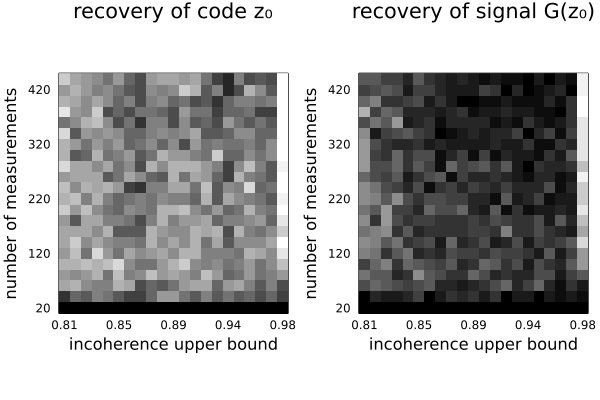

In [43]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-2)
end
p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of code z₀", framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

# m_pred = 600*α_list.^10
# ff(x) = -21/420 * x +(1 + 21*440/420)
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

# m_pred = 150*α_list.^3
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )


M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

p2 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_plot_Full_MNIST_percentage_v2.pdf")



In [95]:


M = sum(phase_matrix_recovery,dims =1)[1,:,:]/20; M[M .>1] .= 1
p1 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of code z₀")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
p2 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of signal G(z₀)")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

plot(p1, p2, layout = 2,  bg =:white)
savefig("figures/Phase_plot_Full_MNIST_error.pdf")

